ASL, 29.04.22

# Introduction

As we've learned, deep neural networks provide (at least partly) hierarchical representations of data, tailored for a given task. 

<img src="https://upload.wikimedia.org/wikipedia/en/8/83/VGG_neural_network.png">

At the end of a high-performance deep neural network, i.e. in the later hidden layers, you'll find a representation for each data instance that makes the task (relatively) easy to solve. 

An idea that can be quite useful in a wide variety of tasks is to _extract_ these representations and use them in other ML models. This is one easy way to combine information extracted by a deep neural network with other useful information for the task at hand. 

We'll use this idea in this notebook by extracting vector representations from the last hidden layer of a trained CNN, and use them to for training other ML models.

We'll do that by using so-called PyTorch **hooks**.

## Hooks in PyTorch

Remember that neural networks are **computational graphs**

![](https://docs.chainer.org/en/latest/_images/googlenet.png)<br>
<center><small>Illustration from <a href="https://docs.chainer.org/en/stable/">https://docs.chainer.org/en/stable/</a> </small></center>

- Hooks are functions injected into these computational graphs by attaching them to tensors or to modules (network layers)
- This allows us to access, and potentially modify, gradients associated with tensors, and the inputs and outputs of layers (modules) as they flow through the computational graphs
- We can attach backward and forward hooks to modules: triggered during backward and forward calculations, respectively.

> In this notebook, we'll attach a hook to the final linear layer of the model to grab the activations before they are passed to the final classification layers. These activations will be a task-specific representation of the data. 

The PyTorch docs has a description of hooks here: https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks. See also the Paperspace blog post: https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/. Here's a video tutorial that explains hooks in quite some detail: https://www.youtube.com/watch?v=syLFCVYua6Q. 

# Setup

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import pandas as pd

In [ ]:
# If Jedi's not working
%config Completer.use_jedi = False

In [ ]:
NB_DIR = Path.cwd()

# Point this to where you stored the MOESM data:
DATA = NB_DIR/'data'/'drug'
RAW_DATA = DATA/'raw'
# Path to image data as defined earlier
IMGDATA = Path('/data2/drugdiscovery/MOESM/molimages/')

In [ ]:
NB_DIR = Path.cwd()
LOCALDATA = NB_DIR/'data'/'drug'/'interim'

In [ ]:
from fastai.vision.all import *

# Load data

In [ ]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    name = data.stem
    
    df = pd.read_csv(data)
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    df = df[['CID', 'SMILES', 'Image', 'Activity']]
    
    return df, name

We remember that we had 7 activity datasets:

In [ ]:
# Datasets available:
data = sorted(list(RAW_DATA.glob('CHEM*cl.csv')))
data

...and that we've generated images of the molecules:

In [ ]:
IMGDATA.ls()

We'll use the **CHEMBL1978** data set in this notebook, as it's one of the smaller ones (and therefore quicker to train models on and to extract features from):

In [ ]:
ds = data[0]
ds

In [ ]:
df, name = get_df(ds)

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df['Activity'].value_counts()

## Create train-val-split and oversample train

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df

In [ ]:
df = val_cols_and_oversample(df)

In [ ]:
df.head()

In [ ]:
df['Activity'].value_counts()

# Create a dataloader

In [ ]:
bs=64

In [ ]:
batch_tfms = [Rotate(max_deg=25, pad_mode='border'), 
              Normalize.from_stats(*imagenet_stats)]

In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=ColSplitter('is_valid'),
    item_tfms=None,
    batch_tfms=batch_tfms
    )

In [ ]:
dls = datablock.dataloaders(df, bs=bs, shuffle_train=True)

In [ ]:
dls.show_batch()

# Train a CNN

In [ ]:
from utils import plot_metrics

We use a pretrained resnet18 model as before, only adding a custom "head" to the model that outputs 128 features (to have fewer activations in the final hidden layer):

In [ ]:
resnet18()

In [ ]:
custom_head = create_head(nf=512, n_out=2, lin_ftrs=[128], concat_pool=True)

In [ ]:
custom_head

In [ ]:
learn = cnn_learner(dls,                             
                arch=resnet18, pretrained=True,  
                custom_head=custom_head,
                wd=2e-4, ps=0.8,                    
                metrics=[accuracy,                  
                         F1Score(), 
                         Precision(), 
                         Recall(), 
                         RocAucBinary(), 
                         MatthewsCorrCoef()],
                cbs=[ShowGraphCallback()])

In [ ]:
learn.model

The below training takes a while. We can rather load the results of a previous run:

In [ ]:
learn = learn.load('chembl1978-model-test-hooks')

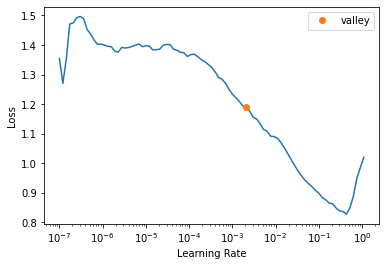

In [30]:
lr = learn.lr_find()

In [31]:
lr.valley

0.0020892962347716093

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.598264,0.402193,0.822600,0.476684,0.325472,0.890323,0.930682,0.469560,00:37
1,0.363147,0.236798,0.901054,0.626932,0.476510,0.916129,0.962038,0.617380,00:37
2,0.252808,0.162805,0.936183,0.719794,0.598291,0.903226,0.971884,0.703990,00:37
3,0.194745,0.143020,0.950234,0.773333,0.659091,0.935484,0.978348,0.760774,00:37
4,0.162597,0.112273,0.957260,0.792023,0.709184,0.896774,0.981343,0.775143,00:38
5,0.142201,0.133590,0.954333,0.786885,0.682464,0.929032,0.979191,0.773356,00:37
6,0.134176,0.111604,0.964286,0.818991,0.758242,0.890323,0.978389,0.802493,00:37
7,0.113144,0.114717,0.962529,0.816092,0.735751,0.916129,0.979137,0.801437,00:37
8,0.109072,0.104854,0.970141,0.848665,0.785714,0.922581,0.982195,0.835521,00:37
9,0.092331,0.118486,0.964871,0.826590,0.748691,0.922581,0.983329,0.812732,00:37


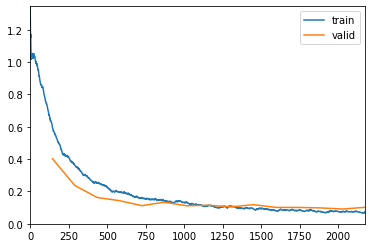

In [103]:
learn.fit_one_cycle(15, slice(lr.valley))

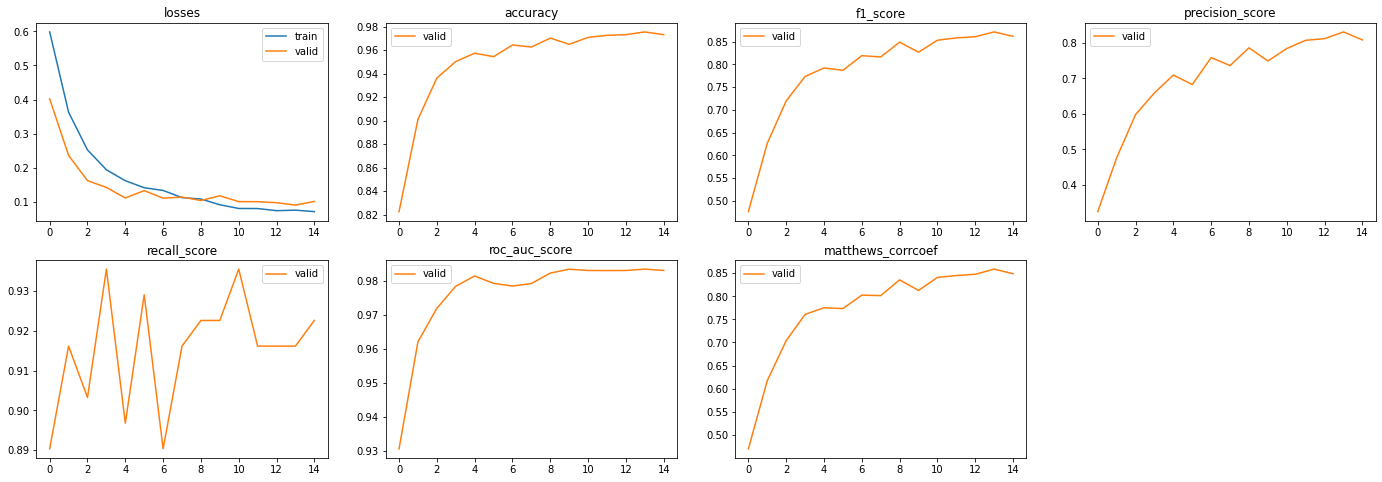

In [104]:
learn.recorder.plot_metrics()

In [105]:
#learn.save('chembl1978-model-test-hooks')

Path('models/chembl1978-model-test-hooks.pth')

### Evaluate

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

# Save activations 

from second final layer. To be used to train a different ML model.

We need to register a **forward hook** at the layer we want to save activations from:

In [ ]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [ ]:
learn.model[-1][-5]

In [ ]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

Create the df again, this time with no oversampling (as that's not necessary).

In [ ]:
df, name = get_df(ds)

df_nodupl = val_cols_and_oversample(df, oversample=False)

No data augmentation:

In [ ]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

We can feed one image at a time throught the model to get the activations

In [ ]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [ ]:
test_df = test_dls.items.reset_index()

In [ ]:
test_df.head()

Each element of the dataset consists of an image (a `PILImage`) and a category (the corresponding activity label):

In [ ]:
test_dls.dataset[0]

In [ ]:
test_dls.dataset[0][0]

In [ ]:
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [ ]:
def get_activations(CID):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    data = get_data(CID)
    img = data[0]
    
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]

    return list(acts)

The below computation takes a while.. We can rather load results computed earlier:

In [ ]:
df_acts = pd.read_csv('data/chembl1978_cnn_activations.csv')

In [46]:
#%%time
#%%capture
#df_nodupl['activations'] = df_nodupl.CID.apply(get_activations)

Now we've stored activations for each image:

In [122]:
#df_nodupl.head()

We split the activations to have one column for each, as they will be treated as separate features later:

In [123]:
df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [124]:
df_acts.drop('activations', axis=1, inplace=True)

Here's the result:

In [ ]:
df_acts.head()

In [ ]:
df_acts.info()

In [47]:
#df_acts.to_csv('data/chembl1978_with_cnn_activations.csv', index=None)

# Add molecular fingerprints

When training the random forest below, we'll compare the results obtained by using _molecular fingerprints_ as features describing molecules. See the notebook `1.0-get_molecular_fingerprints_and_images.ipynb` for the code to generate fingerprints.

In [ ]:
df_ecfp = pd.read_csv(LOCALDATA/'CHEMBL1978_cl_ecfp_1024.csv')

In [ ]:
df_ecfp.head()

In [ ]:
df_ecfp.info()

In [ ]:
df_acts.info()

In [ ]:
df = df_ecfp.merge(df_acts, on='CID')

In [ ]:
df.head()

In [ ]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

Save the dataframe:

In [ ]:
LOCALDATA

In [ ]:
#df.to_csv(LOCALDATA/'chembl1978-data-with-ecfp-activations.csv', index=None)

# Train machine learning models on extracted features

### Split the data

We use the validation data from the CNN model as test data (as it's unseen by the CNN model during training).

In [ ]:
train = df.loc[df.is_valid==False]
test = df.loc[df.is_valid==True]

In [ ]:
X_train, y_train = train.drop(["CID", "SMILES", "Activity", "Image"], axis=1), train["Activity"]

In [ ]:
X_test, y_test = test.drop(["CID", "SMILES", "Activity", "Image"], axis=1), test["Activity"]

In [ ]:
X_train.head()

In [ ]:
y_train.head()

### Logistic Regression and Random forest

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score, 
matthews_corrcoef, precision_score, f1_score)

In [ ]:
def train_lr(X_train, X_test, y_train, y_test, features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Must scale the data for the linear logreg model:
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)
    
    
    lr = LogisticRegression(max_iter=500)
  
    lr.fit(X_train_std, y_train)
    
    y_pred = lr.predict(X_test_std)
    y_pred_prob = lr.predict_proba(X_test_std)
    
    temp=[]
    for j in range(len(y_pred_prob)):
    	temp.append(y_pred_prob[j][1])
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    Recall=recall_score(y_test, y_pred,pos_label=1)
    Precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)
    
    print(f"AUC: {auc.round(5)}, Acc: {acc2.round(5)}, MCC: {mcc.round(5)}")
    print(f"Recall: {Recall.round(5)}, Precision: {Precision.round(5)}, F1_score: {F1_score.round(5)}")

    return auc,acc2,mcc,Recall,Precision,F1_score, lr

In [ ]:
def train_rf(X_train, X_test, y_train, y_test, n_estimators=100, 
             criterion='gini', max_features='log2', features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Following the settings in the paper, `RF_tune.py`
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, min_samples_split=2, 
                                    max_features=max_features, max_leaf_nodes=None, 
                                    bootstrap=False,oob_score=False, n_jobs=-1, 
                                    random_state=100)
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    y_pred_prob = rf.predict_proba(X_test)
    
    temp=[]
    for j in range(len(y_pred_prob)):
    	temp.append(y_pred_prob[j][1])
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    Recall=recall_score(y_test, y_pred,pos_label=1)
    Precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)
    
    print(f"AUC: {auc.round(5)}, Acc: {acc2.round(5)}, MCC: {mcc.round(5)}")
    print(f"Recall: {Recall.round(5)}, Precision: {Precision.round(5)}, F1_score: {F1_score.round(5)}")

    return auc,acc2,mcc,Recall,Precision,F1_score, rf

**Logistic regression:**

In [ ]:
_ = train_lr(X_train, X_test, y_train, y_test, features='ECFP')

In [ ]:
_ = train_lr(X_train, X_test, y_train, y_test, features='act_')

In [ ]:
_ = train_lr(X_train, X_test, y_train, y_test, features='all')

**Random forest:**

In [ ]:
_ = train_rf(X_train, X_test, y_train, y_test, features='ECFP')

In [ ]:
_ = train_rf(X_train, X_test, y_train, y_test, features='act_')

In [ ]:
_ = train_rf(X_train, X_test, y_train, y_test, features='all')